# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to find the Projection Matrix

In [2]:
def get_projection_matrix(world_coord, proj_coord):
    M = []
    for i in range(world_coord.shape[0]):
        M.append([
            -world_coord[i][0], -world_coord[i][1],
            -world_coord[i][2], -1, 0, 0, 0, 0,
            proj_coord[i][0]*world_coord[i][0],
            proj_coord[i][0]*world_coord[i][1],
            proj_coord[i][0]*world_coord[i][2],
            proj_coord[i][0],
        ])
        M.append([
            0, 0, 0, 0,
            -world_coord[i][0], -world_coord[i][1],
            -world_coord[i][2], -1,
            proj_coord[i][1]*world_coord[i][0],
            proj_coord[i][1]*world_coord[i][1],
            proj_coord[i][1]*world_coord[i][2],
            proj_coord[i][1],
        ])
    M = np.array(M)
    
    u, s, v = np.linalg.svd(M)
    p = v[-1, :]
    
    P = np.reshape(p, (3, 4))

    return P

# Function for decomposing the Projection Matrix

In [3]:
def get_params(P):
    H = P[:3, :3]
    h = P[:, 3]
    Hinv = np.linalg.inv(H)

    Xo = np.matmul(-Hinv, h)
    q, r = np.linalg.qr(Hinv)
    r = np.linalg.inv(r)
    r /= r[2, 2]
    r[:, 0] = -r[:, 0]
    q = q.T
        
    return P, Xo, q, r

# Listing out and visualising 20 points

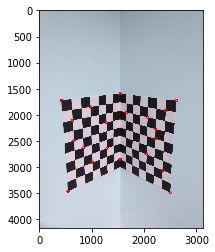

In [4]:
img = cv2.imread('../Camera_calibration_data/calib-object.jpg')
proj_coord = np.array([
    [426, 1722],
    [1547, 1596],
    [2617, 1727],
    [976, 1851],
    [2410, 1917],
    [640, 2106],
    [1660, 1961],
    [2071, 2046],
    [1283, 2151],
    [2224, 2272],
    [664, 2492],
    [2211, 2454],
    [851, 2624],
    [1291, 2639],
    [2052, 2753],
    [1017, 2912],
    [1542, 2847],
    [2355, 3056],
    [2494, 3484],
    [552, 3456]
])
world_coord = np.array([
    [196, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 196, 1],
    [112, 28, 0, 1],
    [0, 28, 168, 1],
    [168, 56, 0, 1],
    [0, 56, 28, 1],
    [0, 56, 112, 1],
    [56, 84, 0, 1],
    [0, 84, 140, 1],
    [168, 112, 0, 1],
    [0, 112, 140, 1],
    [140, 140, 0, 1],
    [56, 168, 0, 1],
    [0, 168, 112, 1],
    [112, 196, 0, 1],
    [0, 224, 0, 1],
    [0, 196, 168, 1],
    [0, 252, 196, 1],
    [196, 252, 0, 1]
    
])

for i in range(proj_coord.shape[0]):
    cv2.circle(img, tuple(proj_coord[i]), 20, (255, 0, 0), 20)
plt.imshow(img)
plt.show()

# Get the the parameters (Part 1)

In [5]:
P = get_projection_matrix(world_coord, proj_coord)
P, Xo, rot_mat, cal_mat = get_params(P)

with np.printoptions(suppress=True):
    print("Projection Matrix ->")
    print(P)
    print("")
    print("Projection Center ->", Xo)
    print("")
    print("Rotation Matrix ->")
    print(rot_mat)
    print("")
    print("Calibration Matrix ->")
    print(cal_mat)

Projection Matrix ->
[[ 0.00278872 -0.00027259 -0.00107257 -0.69451402]
 [ 0.00058862 -0.00301548  0.0006177  -0.71946595]
 [ 0.00000051 -0.00000017  0.00000053 -0.00045058]]

Projection Center -> [407.86273265 -70.70895504 430.90265668]

Rotation Matrix ->
[[-0.72399544 -0.00002326  0.68980475]
 [-0.15889327 -0.97310334 -0.16680175]
 [ 0.67125519 -0.23036904  0.70451869]]

Calibration Matrix ->
[[3634.85968162    1.39036898 1553.46706162]
 [  -0.         3607.10601233 2009.16702769]
 [  -0.            0.            1.        ]]


# RANSAC (Part 2)

In [6]:
def ransac(world_coord, proj_coord):
    maxx = 0
    best_inds = []
    for i in range(50):

        reps = np.random.choice(world_coord.shape[0], 6)
        P = get_projection_matrix(world_coord[reps], proj_coord[reps])

        count = 0
        thresh = 15
        for j in range(world_coord.shape[0]):
            pred = np.matmul(P, world_coord[j])
            pred = np.array([pred[0] / pred[2], pred[1] / pred[2]])
            if np.linalg.norm(pred - proj_coord[j]) < thresh:
                count += 1
        if count > maxx:
            maxx = count
            best_inds = reps

        print("With point indices: ", reps, " we get ", count, "matches")

    P = get_projection_matrix(world_coord[best_inds], proj_coord[best_inds])
    with np.printoptions(suppress=True):
        print("\nBest Projection Matrix ->")
        print(P)
        print("With", maxx, "matches.")

ransac(world_coord, proj_coord)

With point indices:  [16 14 11 13 13 11]  we get  4 matches
With point indices:  [17 10 13  9  2  7]  we get  15 matches
With point indices:  [18  5  3  5  1 16]  we get  10 matches
With point indices:  [15  1  6  0  0  8]  we get  5 matches
With point indices:  [13  4 12  9  4 14]  we get  5 matches
With point indices:  [ 5  6  2 17  0  2]  we get  5 matches
With point indices:  [ 7 14 10  8 10  4]  we get  5 matches
With point indices:  [ 1  6  7 15  1 11]  we get  6 matches
With point indices:  [12  2 10 13 18  2]  we get  5 matches
With point indices:  [17 13 17  6 18 12]  we get  5 matches
With point indices:  [17 19  0  6 10  0]  we get  6 matches
With point indices:  [ 9  3 10 17 14 15]  we get  20 matches
With point indices:  [17 16 13 19  2 11]  we get  16 matches
With point indices:  [ 2 13 17 13  6  2]  we get  4 matches
With point indices:  [15  5 16  6  4 19]  we get  18 matches
With point indices:  [10  7  7  9  8 10]  we get  4 matches
With point indices:  [ 9 13  3  2  

# Correcting Distortion

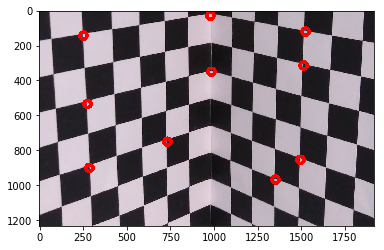

In [7]:
img = cv2.imread('../Camera_calibration_data/Fig1.png')
proj_coord = np.array([
    [254, 146],
    [981, 32],
    [1526, 123],
    [277, 536],
    [987, 352],
    [288, 901],
    [1497, 855],
    [735, 752],
    [1514, 316],
    [1354, 968],
]).astype(np.float32)
world_coord = np.array([
    [140, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 112, 1],
    [140, 56, 0, 1],
    [0, 56, 0, 1],
    [140, 112, 0, 1],
    [0, 112, 112, 1],
    [56, 112, 0, 1],
    [0, 28, 112, 1],
    [0, 140, 84, 1]
]).astype(np.float32)

world_coord = world_coord[:, :3].astype('float32')
proj_coord = proj_coord.astype('float32')

copy = np.copy(img)
for i in range(proj_coord.shape[0]):
    cv2.circle(copy, tuple(proj_coord[i].squeeze()), 20, (255, 0, 0), 20)
plt.imshow(copy)
plt.show()

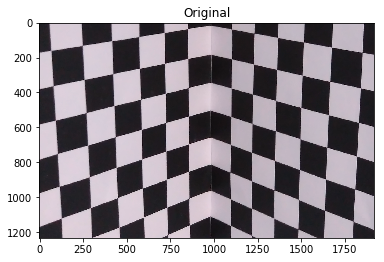

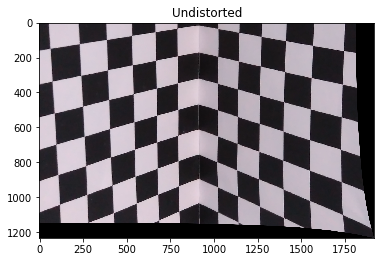

Distortion parameters ->
 [-4.35001587e-35 -1.18741875e-28 -3.46961550e-38 -7.10548241e-38
 -3.24817178e-22]


In [8]:
mtx = (cal_mat)
mtx[0, 1] = 0
mtx[0:2, :] /= np.max(mtx)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([world_coord], [proj_coord], (img.shape[1],img.shape[0]), mtx, None, None, flags=cv2.CALIB_USE_INTRINSIC_GUESS)
newmtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (img.shape[1], img.shape[0]), 1, (img.shape[1], img.shape[0]))
undist = cv2.undistort(img, mtx, dist, None, newmtx)

plt.imshow(img)
plt.title('Original')
plt.show()
plt.imshow(undist)
plt.title("Undistorted")
plt.show()
print("Distortion parameters ->\n", dist.squeeze())